In [3]:
!pip install torchaudio
from IPython.display import Audio

## PyTorch things
import torch
import torchaudio
import torch.nn.functional as F

## Other libs
import matplotlib.pyplot as plt
import glob
import os
import random
from tqdm import tqdm_notebook
import torchsummary
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import pandas as pd
import seaborn as sn

     |████████████████████████████████| 1.9MB 8.0MB/s 


In [4]:
!rm -rf ./*
!wget -O speech_commands_v0.01.tar.gz http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
!tar xzf speech_commands_v0.01.tar.gz 
!ls

--2021-05-27 18:23:58--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.195.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0.  76%[==============>     ]   1.06G  91.3MB/s    in 15s     

2021-05-27 18:24:13 (75.0 MB/s) - Read error at byte 1143816448/1489096277 (Connection reset by peer). Retrying.

--2021-05-27 18:24:14--  (try: 2)  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.195.128|:80... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 1489096277 (1.4G), 345279829 (329M) remaining [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_c

In [5]:
classes = os.listdir()
classes.remove("LICENSE")
classes.remove("README.md")
classes.remove("_background_noise_")
classes.remove("speech_commands_v0.01.tar.gz")
classes.remove("testing_list.txt")
classes.remove("validation_list.txt")
classes.remove(".config")
print(classes)
print("Number of classes", len(classes))

['marvin', 'up', 'two', 'left', 'eight', 'house', 'no', 'seven', 'right', 'sheila', 'dog', 'stop', 'bird', 'down', 'three', 'happy', 'zero', 'six', 'go', 'five', 'tree', 'cat', 'wow', 'bed', 'one', 'nine', 'off', 'on', 'yes', 'four']
Number of classes 30


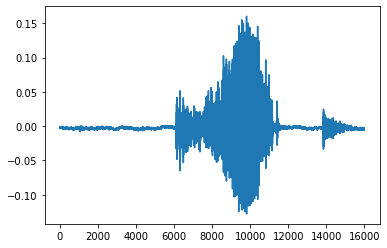

In [6]:
Audio("bed/1528225c_nohash_2.wav")
waveform, sample_rate = torchaudio.load("cat/004ae714_nohash_0.wav")
plt.plot(waveform.t())

In [7]:
## Read the test list
with open("testing_list.txt") as testing_f:
  testing_list = [x.strip() for x in testing_f.readlines()]

## Read the val list
with open("validation_list.txt") as val_f:
  validation_list = [x.strip() for x in val_f.readlines()]  

print("Number of testing samples", len(testing_list))
print("Number of validation samples", len(validation_list))

## Construct a train list
training_list = []
for c in classes:
  training_list += glob.glob(c + "/*")

training_list = list(filter(lambda x : not x in testing_list and not x in validation_list, training_list))
print("Number of training samples", len(training_list))

Number of testing samples 6835
Number of validation samples 6798
Number of training samples 51088


/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:358: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


torch.Size([1, 12, 81])


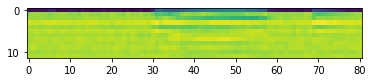

In [8]:
mfcc = torchaudio.transforms.MFCC(n_mfcc=12, log_mels=True)(waveform)
plt.figure()
plt.imshow(mfcc[0].detach().numpy())
print(mfcc.shape)

In [9]:
class SpeechDataset(torch.utils.data.Dataset):

  def __init__(self, classes, file_list):

    self.classes = classes

    # create a map from class name to integer
    self.class_to_int = dict(zip(classes, range(len(classes))))

    # store the file names
    self.samples = file_list

    # store our MFCC transform
    self.mfcc_transform = torchaudio.transforms.MFCC(n_mfcc=12, log_mels=True)

  def __len__(self):
    return len(self.samples)

  def __getitem__(self,i):
    with torch.no_grad():
      # load a normalized waveform
      waveform,_ = torchaudio.load(self.samples[i])

      # if the waveform is too short (less than 1 second) we pad it with zeroes
      if waveform.shape[1] < 16000:
        waveform = F.pad(input=waveform, pad=(0, 16000 - waveform.shape[1]), mode='constant', value=0)

      # then, we apply the transform
      mfcc = self.mfcc_transform(waveform).squeeze(0).transpose(0,1)

    # get the label from the file name
    label = self.samples[i].split("/")[0]

    # return the mfcc coefficient with the sample label
    return mfcc, self.class_to_int[label]

In [10]:
train_set = SpeechDataset(classes, training_list)
test_set =SpeechDataset(classes, testing_list)

print(train_set[5][0].shape)

torch.Size([81, 12])


/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:358: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


In [11]:
train_dl = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_set, batch_size=16)
print(next(iter(train_dl)))

[tensor([[[-1.2740e+02, -1.2760e+01,  2.0400e+00,  ...,  4.6429e+00,
          -1.1296e+00, -8.0980e-01],
         [-1.1289e+02, -2.7041e+01,  1.4706e+00,  ...,  4.0146e+00,
          -2.0393e+00,  1.0963e+00],
         [-1.1946e+02, -2.2244e+01,  3.7043e+00,  ...,  4.7818e+00,
          -3.3345e+00,  2.4520e+00],
         ...,
         [-1.2425e+02,  1.8986e+00, -5.2306e+00,  ...,  1.6198e+00,
          -5.6681e+00,  1.6401e+00],
         [-1.2537e+02,  1.8386e+00, -6.3471e+00,  ...,  3.3403e+00,
          -4.0581e+00,  2.7159e+00],
         [-1.2583e+02,  8.3375e-01, -8.5931e+00,  ...,  3.1426e+00,
          -2.5650e+00,  2.8245e+00]],

        [[-1.2751e+02,  8.2417e+00, -1.6991e-01,  ...,  2.4856e+00,
           7.1145e-01,  1.4422e+00],
         [-1.2547e+02,  1.2489e+01,  5.1150e+00,  ...,  3.7124e-01,
          -1.3284e+00,  1.3314e+00],
         [-1.2658e+02,  1.0516e+01,  3.9379e+00,  ..., -1.3967e+00,
          -1.9223e+00,  1.0429e+00],
         ...,
         [-1.5630e+02,  

In [12]:
class SpeechRNN(torch.nn.Module):

  def __init__(self):
    super(SpeechRNN, self).__init__()

    self.rnn = torch.nn.LSTM(input_size = 12, 
                              hidden_size= 256, 
                              num_layers = 2, 
                              batch_first=True)

    self.out_layer = torch.nn.Linear(256, 30)

    self.softmax = torch.nn.LogSoftmax(dim=1)

  def forward(self, x):

    out, _ = self.rnn(x)

    x = self.out_layer(out[:,-1,:])

    return self.softmax(x)

In [13]:
##RE-RUN THIS CODE TO GET A "NEW" NETWORK

LEARNING_RATE = 0.001

## Create an instance of our network
net = SpeechRNN()

## Move it to the GPU
net = net.cuda()

# Negative log likelihood loss
criterion = torch.nn.NLLLoss()

# Adam optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [14]:
## NUMBER OF EPOCHS TO TRAIN
N_EPOCHS = 5

epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = [], [], [], []

for e in range(N_EPOCHS):

  print("EPOCH:",e)

  ### TRAINING LOOP
  running_loss = 0
  running_accuracy = 0

  ## Put the network in training mode
  net.train()

  for i, batch in enumerate(tqdm_notebook(train_dl)):

    # Get a batch from the dataloader
    x = batch[0]
    labels = batch[1]

    # move the batch to GPU
    x = x.cuda()
    labels = labels.cuda()

    # Compute the network output
    y = net(x)

    # Compute the loss
    loss = criterion(y, labels)

    # Reset the gradients
    optimizer.zero_grad()

    # Compute the gradients
    loss.backward()

    # Apply one step of the descent algorithm to update the weights
    optimizer.step()

    ## Compute some statistics
    with torch.no_grad():
      running_loss += loss.item()
      running_accuracy += (y.max(1)[1] == labels).sum().item()

  print("Training accuracy:", running_accuracy/float(len(train_set)),
        "Training loss:", running_loss/float(len(train_set)))

  epoch_loss.append(running_loss/len(train_set))
  epoch_acc.append(running_accuracy/len(train_set))

  ### VALIDATION LOOP
  ## Put the network in validation mode
  net.eval()

  running_test_loss = 0
  running_test_accuracy = 0

  for i, batch in enumerate(test_dl):

    with torch.no_grad():
      # Get a batch from the dataloader
      x = batch[0]
      labels = batch[1]

      # move the batch to GPU
      x = x.cuda()
      labels = labels.cuda()

      # Compute the network output
      y= net(x)

      # Compute the loss
      loss = criterion(y, labels)

      running_test_loss += loss.item()
      running_test_accuracy += (y.max(1)[1] == labels).sum().item()

  print("Validation accuracy:", running_test_accuracy/float(len(test_set)),
        "Validation loss:", running_test_loss/float(len(test_set)))

  epoch_test_loss.append(running_test_loss/len(test_set))
  epoch_test_acc.append(running_test_accuracy/len(test_set))


EPOCH: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Training accuracy: 0.5474279674287504 Training loss: 0.09159128374259393
Validation accuracy: 0.7300658376005852 Validation loss: 0.055814446938369254
EPOCH: 1



Training accuracy: 0.8127740369558409 Training loss: 0.039222181877127164
Validation accuracy: 0.840087783467447 Validation loss: 0.034395976446776076
EPOCH: 2



Training accuracy: 0.8671116504854369 Training loss: 0.027608190596219172
Validation accuracy: 0.8534016093635699 Validation loss: 0.030607832245352927
EPOCH: 3



Training accuracy: 0.8915009395552772 Training loss: 0.022662537525839067
Validation accuracy: 0.8735918068763716 Validation loss: 0.026024645508758194
EPOCH: 4



Training accuracy: 0.9071014719699342 Training loss: 0.019254747811884108
Validation accuracy: 0.8956839795171909 Validation loss: 0.022868410925540646


In [15]:
!pip install transformers==4.4.0 
!pip install torchaudio
!pip install ffmpeg-python

     |████████████████████████████████| 2.1MB 6.7MB/s 
     |████████████████████████████████| 901kB 49.0MB/s 
     |████████████████████████████████| 3.3MB 43.9MB/s 


In [16]:
import scipy
import torchaudio
import torch
from transformers import Wav2Vec2Processor
from transformers import Wav2Vec2ForCTC
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [25]:
audio, sr = get_audio()
scipy.io.wavfile.write('./recording.wav', sr, audio)

In [26]:
waveform, sample_rate = torchaudio.load("./recording.wav")
Resample = torchaudio.transforms.Resample(orig_freq = 48000, new_freq = 16000, resampling_method = 'sinc_interpolation')
waveform, sample_rate = Resample.forward(waveform), 16000

In [27]:
def interactive():
  model.to("cuda")
  input_values = processor(
      waveform[0].tolist(), 
      sampling_rate=sample_rate, 
      return_tensors="pt"
  ).input_values.to("cuda")

  with torch.no_grad():
    logits = model(input_values).logits

  pred_ids = torch.argmax(logits, dim=-1)
  # batch["pred_str"] = processor.batch_decode(pred_ids)[0]
  pred_str = processor.batch_decode(pred_ids)[0]
  return pred_str.lower()

interactive()

'hallo'